In [1]:
%%capture
!pip install fairlearn

In [2]:
#@markdown Load modules
import numpy as np
from IPython.display import display, Markdown, Latex
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.preprocessing import CorrelationRemover
from fairlearn.adversarial import AdversarialFairnessClassifier
from fairlearn.metrics import MetricFrame
import fairlearn.datasets as fdata
from fairlearn.metrics import (demographic_parity_difference, demographic_parity_ratio,
                               selection_rate_difference, false_negative_rate_difference,
                               false_positive_rate_difference, equalized_odds_ratio,
                               false_negative_rate, false_positive_rate)

# Load and preprocess the data

In [3]:
#@markdown Load and read about the dataset.
# get datast from fairlearn and show description
dataset = fdata.fetch_diabetes_hospital()

display(Markdown(dataset.DESCR))

# save dataframe and features
x_raw = dataset.data
# y_raw = np.array(dataset.target)
feature_names = dataset.feature_names

The "Diabetes 130-Hospitals" dataset represents 10 years of clinical care at 130 U.S. hospitals and delivery networks, collected from 1999 to 2008. Each record represents the hospital admission record for a patient diagnosed with diabetes whose stay lasted between one to fourteen days. The features describing each encounter include demographics, diagnoses, diabetic medications, number of visits in the year preceding the encounter, and payer information, as well as whether the patient was readmitted after release, and whether the readmission occurred within 30 days of the release.

The original "Diabetes 130-Hospitals" dataset was collected by Beata Strack, Jonathan P. DeShazo, Chris Gennings, Juan L. Olmo, Sebastian Ventura, Krzysztof J. Cios, and John N. Clore in 2014.

This version of the dataset was derived by the Fairlearn team for the SciPy 2021 tutorial "Fairness in AI Systems: From social context to practice using Fairlearn". In this version, the target variable "readmitted" is binarized into whether the patient was re-admitted within thirty days. The full dataset pre-processing script can be found on GitHub: https://github.com/fairlearn/talks/blob/main/2021_scipy_tutorial/preprocess.py

Downloaded from openml.org.

You can read more about the dataset [here](https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html). In this description, we see that two features, `readmitted` and `readmit_binary`, are other representations of the same outcome, so we drop them from the set of predictors.

In [4]:
#@markdown Down sample to make runtimes reasonable
x_raw = x_raw.sample(frac=0.1, random_state=123)

In [5]:
y_raw = x_raw['readmit_binary']
x_raw = x_raw.drop(columns=['readmitted', 'readmit_binary'])
feature_names = feature_names[:-2]

In [6]:
#@markdown Look at the first few rows of the data.
x_raw.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,max_glu_serum,A1Cresult,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days
65884,Caucasian,Male,'Over 60 years','Discharged to Home',Emergency,3,Missing,49,6,27,...,NaN,NaN,Up,Ch,Yes,False,False,False,True,False
86278,Caucasian,Female,'Over 60 years',Other,Referral,5,Missing,57,0,21,...,NaN,NaN,No,Ch,Yes,True,False,False,True,False
30000,Caucasian,Male,'30-60 years','Discharged to Home',Other,4,Other,37,2,9,...,NaN,NaN,No,No,No,False,False,False,False,False
51185,Caucasian,Male,'30-60 years',Other,Other,9,InternalMedicine,61,6,27,...,NaN,>8,No,Ch,Yes,False,False,True,False,True
53902,Caucasian,Female,'30-60 years','Discharged to Home',Referral,7,Other,23,0,13,...,NaN,NaN,No,No,Yes,True,False,True,True,False


## data inspectation

In [7]:
#@markdown drop the rows with 'Unknown/Invalid' values for gender

# drop these 3 rows
print(x_raw.shape)
rows_to_keep = x_raw.gender != 'Unknown/Invalid'
x_raw = x_raw[rows_to_keep]
y_raw = y_raw[rows_to_keep]
print(x_raw.shape)

(10177, 22)
(10177, 22)


In [8]:
#@markdown
unique_feature_values = x_raw.apply(lambda col: col.unique())
unique_feature_values

race                        [Caucasian, AfricanAmerican, Unknown, Other, A...
gender                                                         [Male, Female]
age                         ['Over 60 years', '30-60 years', '30 years or ...
discharge_disposition_id                        ['Discharged to Home', Other]
admission_source_id                              [Emergency, Referral, Other]
time_in_hospital              [3, 5, 4, 9, 7, 8, 11, 2, 1, 6, 12, 13, 14, 10]
medical_specialty           [Missing, Other, InternalMedicine, Emergency/T...
num_lab_procedures          [49, 57, 37, 61, 23, 65, 47, 35, 51, 22, 46, 4...
num_procedures                                          [6, 0, 2, 1, 3, 4, 5]
num_medications             [27, 21, 9, 13, 40, 17, 34, 10, 19, 11, 6, 14,...
primary_diagnosis           [Other, Diabetes, 'Respiratory Issues', 'Muscu...
number_diagnoses                  [9, 5, 7, 4, 6, 8, 3, 2, 1, 16, 15, 13, 11]
max_glu_serum                                         [nan, Norm

In [9]:
#@markdown
binary_features = unique_feature_values.index[[len(x) == 2 for x in unique_feature_values]].values
print(f'Binary features: {binary_features}')
categorical_features = unique_feature_values.index[[len(x) > 2 and isinstance(x[0], str) for x in unique_feature_values]].values
print(f'Categorical features: {categorical_features}')

Binary features: ['gender' 'discharge_disposition_id' 'change' 'diabetesMed' 'medicare'
 'medicaid' 'had_emergency' 'had_inpatient_days' 'had_outpatient_days']
Categorical features: ['race' 'age' 'admission_source_id' 'medical_specialty'
 'primary_diagnosis' 'insulin']


In [10]:
#@markdown standardize data types
for col_name in feature_names:
    if col_name in categorical_features:
        x_raw[col_name] = x_raw[col_name].astype('category')
    elif col_name in binary_features:  # redundant for clarity
        # turn into int column
        integer_col = (x_raw[col_name] == unique_feature_values[col_name][0]).astype(int)
        new_name = f'{col_name}_{unique_feature_values[col_name][0]}'
        x_raw[new_name] = integer_col
        x_raw.drop(columns=[col_name], inplace=True)

In [11]:
%%capture
x_raw.apply(lambda col: col.unique())

In [12]:
x_raw.dtypes

race                                             category
age                                              category
admission_source_id                              category
time_in_hospital                                    int64
medical_specialty                                category
num_lab_procedures                                  int64
num_procedures                                      int64
num_medications                                     int64
primary_diagnosis                                category
number_diagnoses                                    int64
max_glu_serum                                      object
A1Cresult                                          object
insulin                                          category
gender_Male                                         int64
discharge_disposition_id_'Discharged to Home'       int64
change_Ch                                           int64
diabetesMed_Yes                                     int64
medicare_False

In [13]:
#@markdown One-hot encode categorical features
x_numeric = pd.get_dummies(x_raw)
display(x_numeric.head())

# get one-hot and numeric column names
numeric_cols = x_numeric.dtypes.index[x_numeric.dtypes == 'int64'].values
one_hot_cols = x_numeric.dtypes.index[x_numeric.dtypes != 'int64'].values

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_diagnoses,gender_Male,discharge_disposition_id_'Discharged to Home',change_Ch,diabetesMed_Yes,medicare_False,...,max_glu_serum_>200,max_glu_serum_>300,max_glu_serum_Norm,A1Cresult_>7,A1Cresult_>8,A1Cresult_Norm,insulin_Down,insulin_No,insulin_Steady,insulin_Up
65884,3,49,6,27,9,1,1,1,1,1,...,False,False,False,False,False,False,False,False,False,True
86278,5,57,0,21,9,0,0,1,1,0,...,False,False,False,False,False,False,False,True,False,False
30000,4,37,2,9,5,1,1,0,0,1,...,False,False,False,False,False,False,False,True,False,False
51185,9,61,6,27,9,1,0,1,1,1,...,False,False,False,False,True,False,False,True,False,False
53902,7,23,0,13,7,0,1,0,1,0,...,False,False,False,False,False,False,False,True,False,False


 # TODO: Split train, test data 80 train / 20 test


In [14]:
# write your code here

X_train, X_test, y_train, y_test = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=123)

# Problem 4, Part (a)
### **Train a baseline Random Forest (RF) (sklearn RandomForestClassifier) model and report metrics**

### Train a random forest model - Baseline

In [15]:
# write your code here
# initialize a model with RandomForestClassifier
n_estimators = 1
rfc_a = RandomForestClassifier(n_estimators=n_estimators, random_state=123)

# train the model with the training data split
rfc_a.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1, random_state=123)

### Report metrics

Calculate metrics with Fairlearn MetricFrame


In [ ]:
# write your code here

# get model's prediction for the test set
y_pred_baseline_a = rfc_a.predict(X_test)

# use MetricFrame to get the results

metric_dict = {
    'accuracy': accuracy_score,
    'precision': precision_score,
    'recall': recall_score,
    'FNR': false_negative_rate,
    'FPR': false_positive_rate,
    'false negative rate difference': false_negative_rate_difference,
    'false positive rate difference': false_positive_rate_difference,
    'demographic parity ratio': demographic_parity_ratio,
    'equalized odds ratio': equalized_odds_ratio,
    'selection rate difference': selection_rate_difference,
}

sample_params = {
	'false negative rate difference':
		{ 'sensitive_features': X_test['gender_Male'] },
    'false positive rate difference':
        { 'sensitive_features': X_test['gender_Male'] },
    'demographic parity ratio':
        { 'sensitive_features': X_test['gender_Male'] },
    'equalized odds ratio':
        { 'sensitive_features': X_test['gender_Male'] },
    'selection rate difference':
        { 'sensitive_features': X_test['gender_Male'] },
}

metric_frame_a = MetricFrame(
    metrics=metric_dict,
    y_true=y_test,
    y_pred=y_pred_baseline_a,
    sensitive_features=X_test['gender_Male'],
    sample_params=sample_params
)


Print Results

In [17]:
# store overall and group metrics in a pandas DataFrame
overall_metrics_a = pd.DataFrame(metric_frame_a.overall.to_dict(), index=['Overall'])

group_metrics_a = pd.DataFrame(metric_frame_a.by_group.to_dict())
group_metrics_a.rename(index={0: 'Female', 1: 'Male'}, inplace=True)

# concatenate overall and group metrics DataFrames
performance_table_a = pd.concat([overall_metrics_a, group_metrics_a.iloc[:,:5]], axis=0)
performance_table_a

,accuracy,precision,recall,FNR,FPR,false negative rate difference,false positive rate difference,demographic parity ratio,equalized odds ratio,selection rate difference
Overall,0.516208,0.474308,0.514469,0.485531,0.482321,0.035991,0.007635,0.957293,0.932045,0.021635
Female,0.521510,0.495667,0.529630,0.470370,0.485810,NaN,NaN,NaN,NaN,NaN
Male,0.509476,0.445977,0.493639,0.506361,0.478175,NaN,NaN,NaN,NaN,NaN


# Problem 4, Part (b)

Train another classifier with the following value of hyperparameters

In [18]:
# write your code here
n_estimators = 1000
max_depth = 10

# initialize a model with RandomForestClassifier
rfc_b = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=123)

# train the model with the training data split
rfc_b.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=123)

Calculate metrics with Fairlearn MetricFrame
and print the results

In [19]:
# get model's prediction for the test set
y_pred_baseline_b = rfc_b.predict(X_test)


# use MetricFrame to get the results
metric_frame_b = MetricFrame(
    metrics=metric_dict,
    y_true=y_test,
    y_pred=y_pred_baseline_b,
    sensitive_features=X_test['gender_Male'],
    sample_params=sample_params
)

In [20]:
# store overall and group metrics in a pandas DataFrame
overall_metrics_b = pd.DataFrame(metric_frame_b.overall.to_dict(), index=['Overall'])

group_metrics_b = pd.DataFrame(metric_frame_b.by_group.to_dict())
group_metrics_b.rename(index={0: 'Female', 1: 'Male'}, inplace=True)

# concatenate overall and group metrics DataFrames
performance_table_b = pd.concat([overall_metrics_b, group_metrics_b.iloc[:,:5]], axis=0)
performance_table_b

,accuracy,precision,recall,FNR,FPR,false negative rate difference,false positive rate difference,demographic parity ratio,equalized odds ratio,selection rate difference
Overall,0.621807,0.612414,0.475884,0.524116,0.254760,0.079234,0.0453,0.822476,0.835546,0.068578
Female,0.622476,0.625000,0.509259,0.490741,0.275459,NaN,NaN,NaN,NaN,NaN
Male,0.620959,0.592982,0.430025,0.569975,0.230159,NaN,NaN,NaN,NaN,NaN


# Problem 4, Part (c)
### **Fit Fairlean Adversarial Debiaser**

Experiment with the alpha parameter - which value of alpha produces the fairest and most accurate classifier? Does such a value exist?

In [21]:
# create a DataFrame to store the metric values for different alpha and seed values
metric_values_df = pd.DataFrame({col: [0.0] * 10 for col in [f'overall_a{i}_m{j}' for i in range(1, 5) for j in range(1, 11)]})
metric_values_df = metric_values_df.join(pd.DataFrame({col: [0.0] * 10 for col in [f'female_a{i}_m{j}' for i in range(1, 5) for j in range(1, 6)]}))
metric_values_df = metric_values_df.join(pd.DataFrame({col: [0.0] * 10 for col in [f'male_a{i}_m{j}' for i in range(1, 5) for j in range(1, 6)]}))
metric_values_df.head()

,overall_a1_m1,overall_a1_m2,overall_a1_m3,overall_a1_m4,overall_a1_m5,overall_a1_m6,overall_a1_m7,overall_a1_m8,overall_a1_m9,overall_a1_m10,...,male_a3_m1,male_a3_m2,male_a3_m3,male_a3_m4,male_a3_m5,male_a4_m1,male_a4_m2,male_a4_m3,male_a4_m4,male_a4_m5
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#@markdown Fit the AdversarialFairnessClassifier here.
#@markdown Use these hyperparameters, while varying the `alpha` parameter:
#@markdown - backend='tensorflow',
#@markdown - predictor_model=[128,64,32,16,8],
#@markdown - adversary_model=[32,16,8],
#@markdown - learning_rate=0.001,
#@markdown - epochs=3,
#@markdown - batch_size=16,
#@markdown - constraints='demographic_parity',
#@markdown - random_state=seed,
#@markdown - shuffle=True
seeds = [123,223,323,423,523,623,723,823,923,1023]
alphas = [0.0,0.3,0.7,1.0]
metric_list = list(metric_dict.keys())

# loop over each seed and alpha value
for i, seed in enumerate(seeds):
    for j, alpha in enumerate(alphas):
        X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=seed)
        afc = AdversarialFairnessClassifier(backend='tensorflow',
            predictor_model=[128,64,32,16,8],
            # predictor_model=[4],
            adversary_model=[32,16,8],
            # adversary_model=[4],
            learning_rate=0.001,
            epochs=3,
            # epochs=1,
            batch_size=16,
            constraints='demographic_parity',
            random_state=seed,
            shuffle=True,
            alpha=alpha)
        afc.fit(X_train_c, y_train_c, sensitive_features=X_train_c['gender_Male'])
        y_pred_c = afc.predict(X_test_c)

        sample_params_c = {
            'false negative rate difference':
                { 'sensitive_features': X_test_c['gender_Male'] },
            'false positive rate difference':
                { 'sensitive_features': X_test_c['gender_Male'] },
            'demographic parity ratio':
                { 'sensitive_features': X_test_c['gender_Male'] },
            'equalized odds ratio':
                { 'sensitive_features': X_test_c['gender_Male'] },
            'selection rate difference':
                { 'sensitive_features': X_test_c['gender_Male'] },
        }

        metric_frame_c = MetricFrame(
            metrics=metric_dict,
            y_true=y_test_c,
            y_pred=y_pred_c,
            sensitive_features=X_test_c['gender_Male'],
            sample_params=sample_params_c
        )

        overall_metrics_c = metric_frame_c.overall.to_dict()
        group_metrics_c = pd.DataFrame(metric_frame_c.by_group.to_dict())

        # store the metric values
        for k, metric in enumerate(metric_list):
            metric_values_df.iat[i, j*10+k] = overall_metrics_c[metric]
            if k < 5:
                metric_values_df.iat[i, 40+j*5+k] = group_metrics_c.iat[0,k]
                metric_values_df.iat[i, 60+j*5+k] = group_metrics_c.iat[1,k]


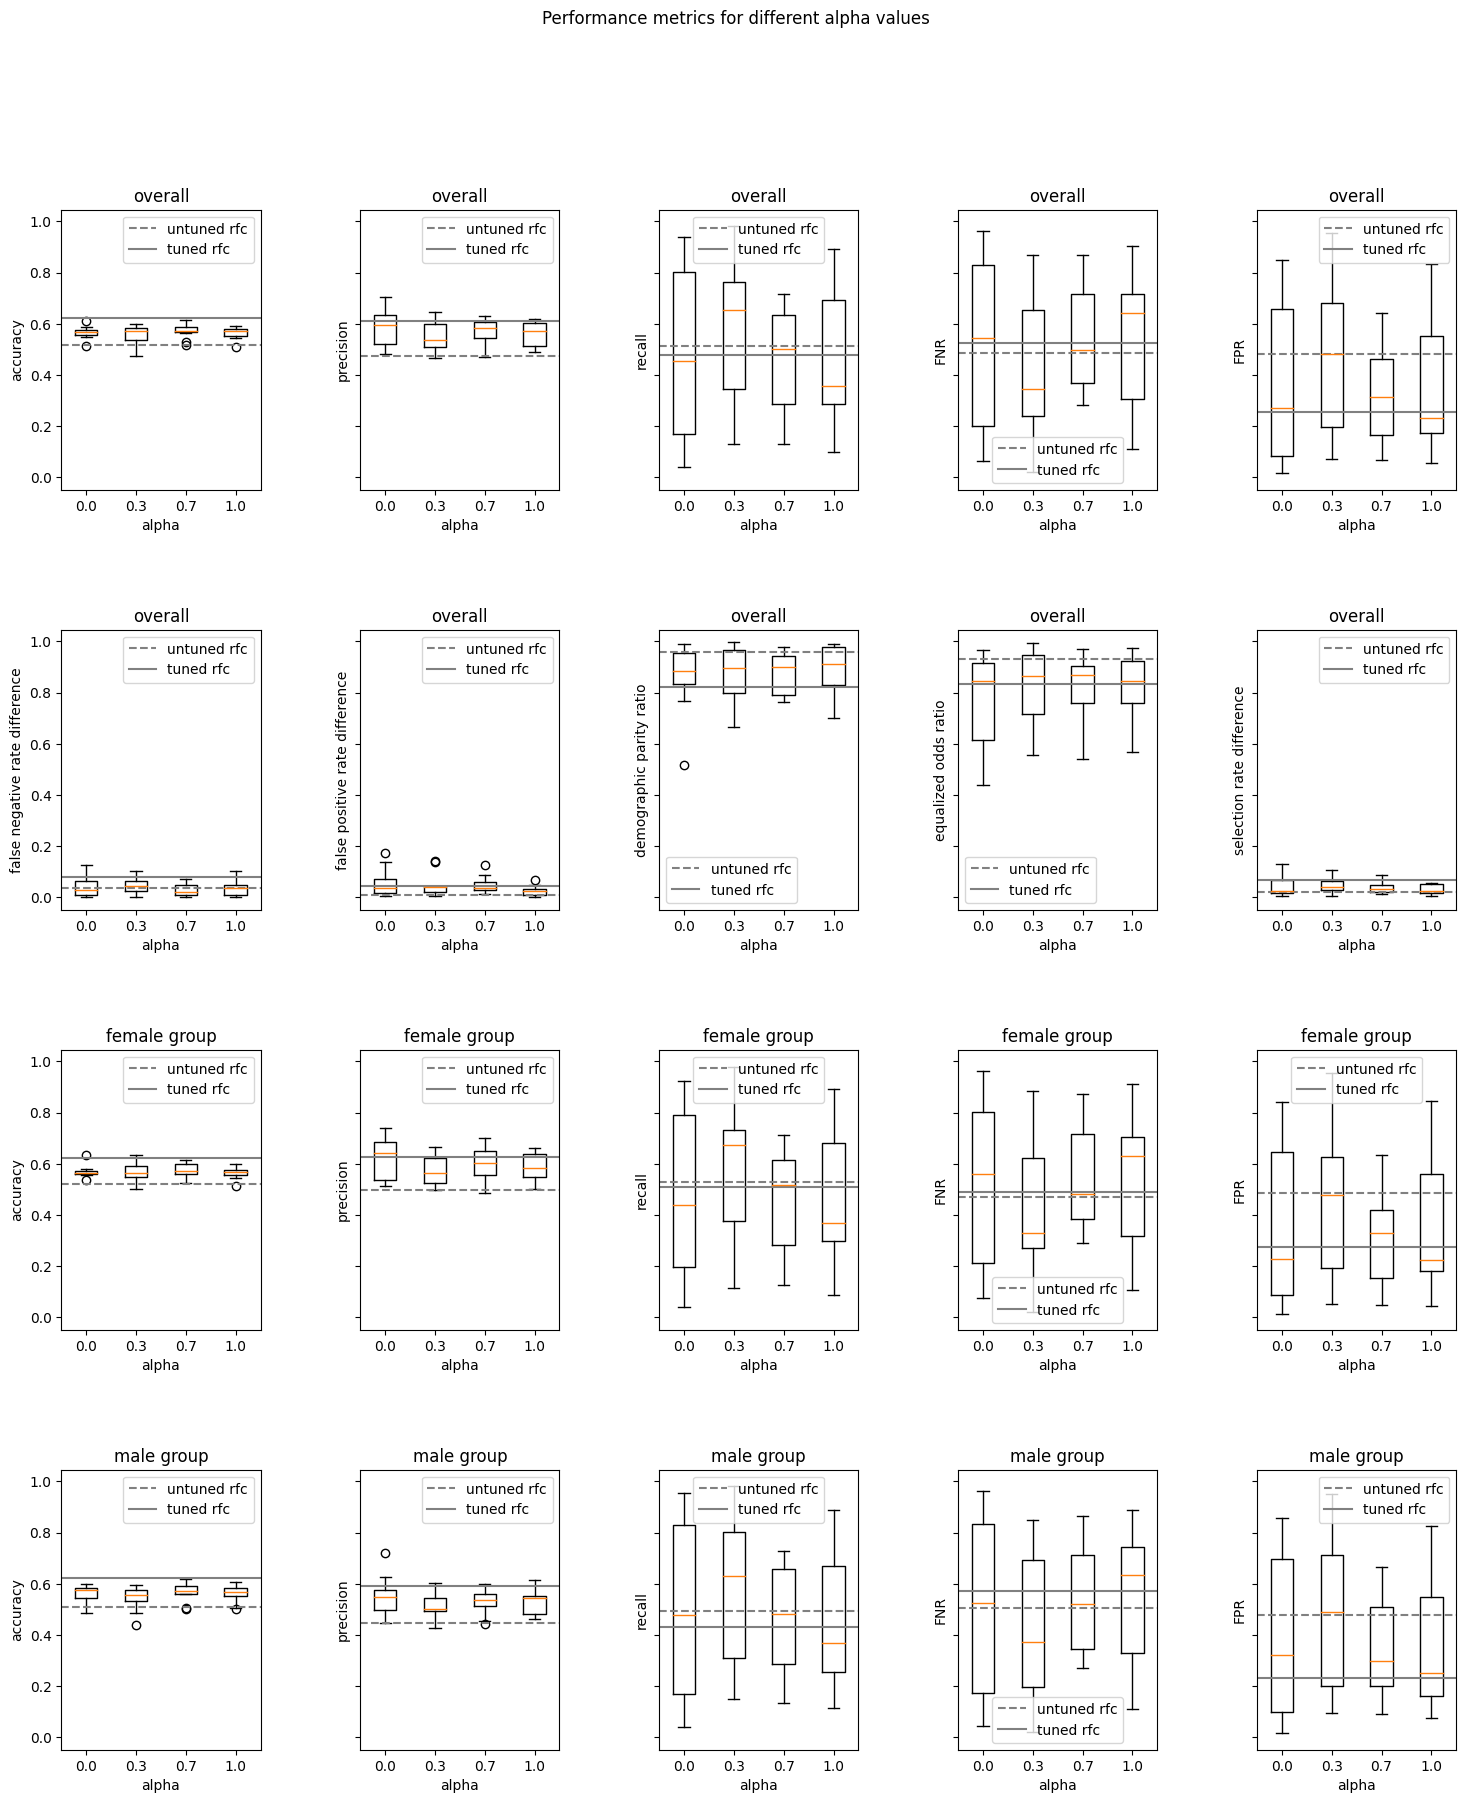

In [23]:
#@markdown ### Plot all our metrics as line plots while varying alpha
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(18, 20), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Performance metrics for different alpha values')

for i, metric in enumerate(metric_list):
    # overall plot for that metric
    ax = axs.flatten()[i]
    data = metric_values_df.iloc[:,[i,i+10,i+20,i+30]]
    ax.boxplot(data, labels=alphas)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('overall')
    ax.axhline(performance_table_a[metric].values[0], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[0], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

    if i < 5:
        # female group plot for that metric
        ax = axs.flatten()[i+10]
        data = metric_values_df.iloc[:,[i+40,i+45,i+50,i+55]]
        ax.boxplot(data, labels=alphas)
        ax.set_xlabel('alpha')
        ax.set_ylabel(metric)
        ax.set_title('female group')
        ax.axhline(performance_table_a[metric].values[1], color='grey', linestyle='--', label='untuned rfc')
        ax.axhline(performance_table_b[metric].values[1], color='grey', linestyle='-', label='tuned rfc')
        ax.legend()

        # male group plot for that metric
        ax = axs.flatten()[i+15]
        data = metric_values_df.iloc[:,[i+60,i+65,i+70,i+75]]
        ax.boxplot(data, labels=alphas)
        ax.set_xlabel('alpha')
        ax.set_ylabel(metric)
        ax.set_title('male group')
        ax.axhline(performance_table_a[metric].values[2], color='grey', linestyle='--', label='untuned rfc')
        ax.axhline(performance_table_b[metric].values[2], color='grey', linestyle='-', label='tuned rfc')
        ax.legend()

plt.show()

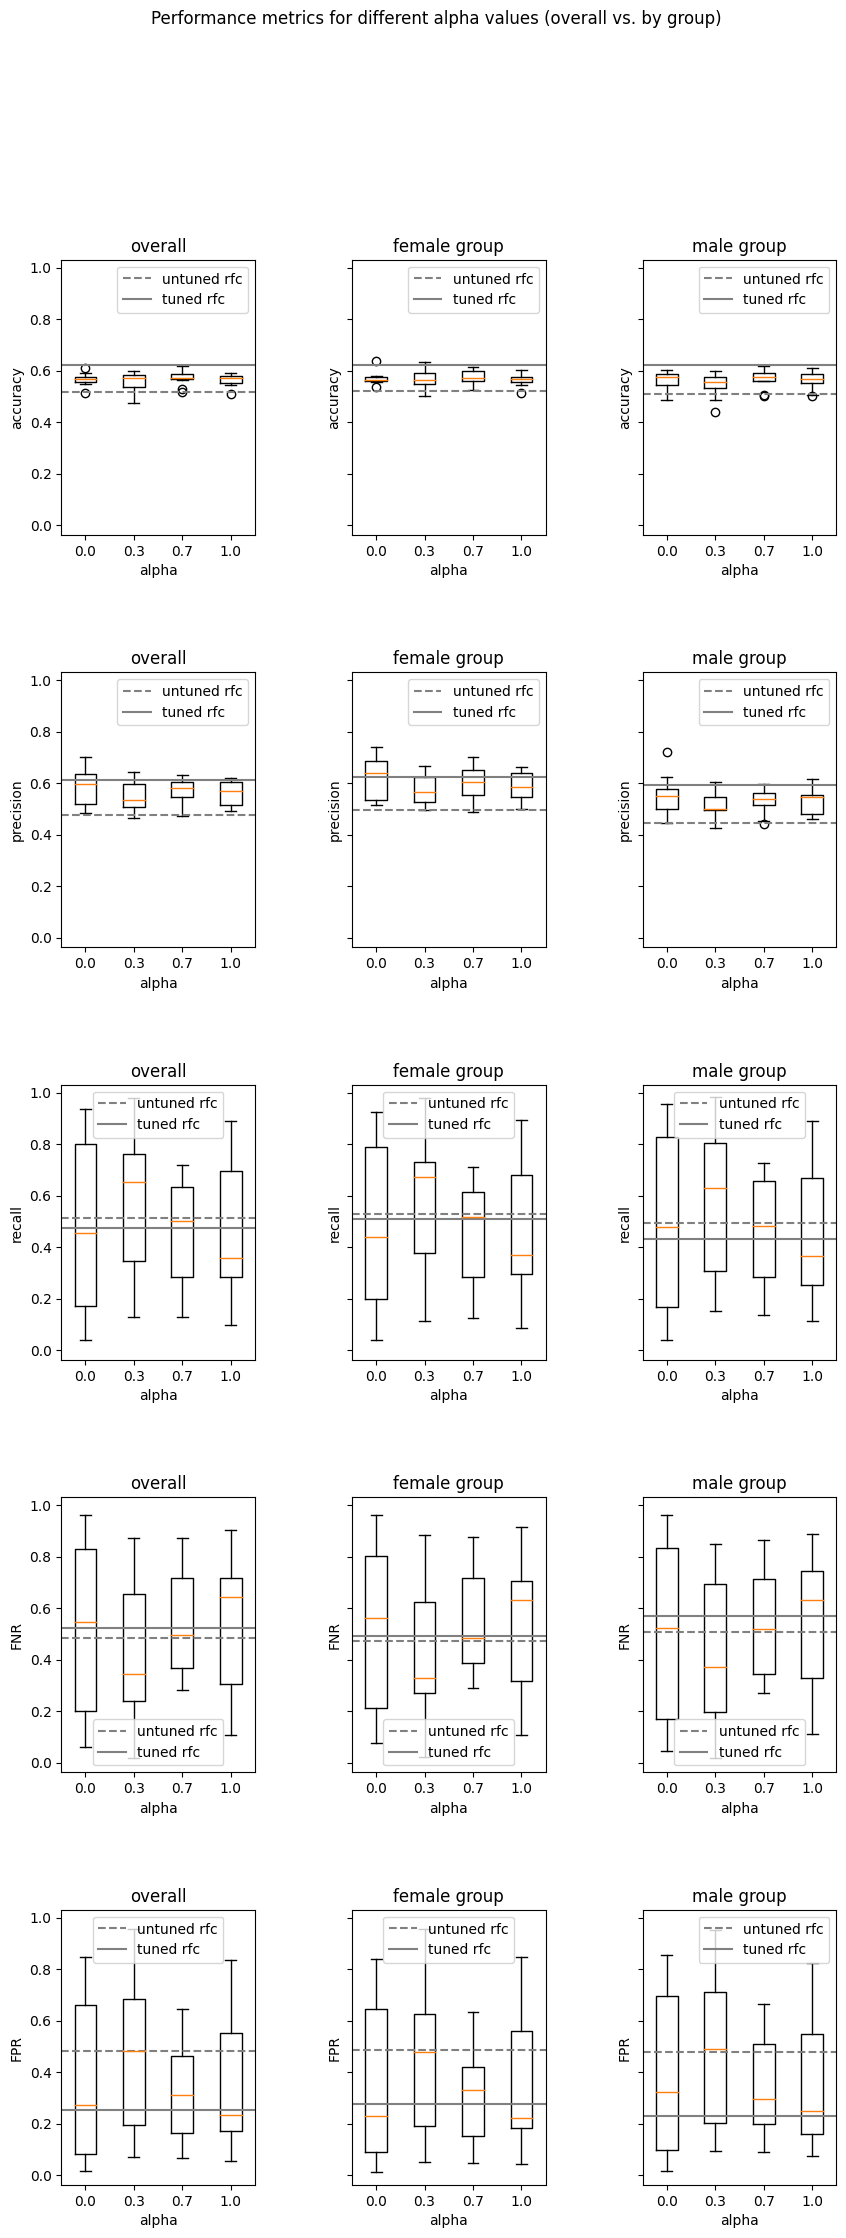

In [24]:
# inspection for overall vs. by group performance
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(10, 25), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Performance metrics for different alpha values (overall vs. by group)')

for i, metric in enumerate(metric_list[:5]):
    # overall plot for that metric
    ax = axs.flatten()[3*i]
    data = metric_values_df.iloc[:,[i,i+10,i+20,i+30]]
    ax.boxplot(data, labels=alphas)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('overall')
    ax.axhline(performance_table_a[metric].values[0], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[0], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

    # female group plot for that metric
    ax = axs.flatten()[3*i+1]
    data = metric_values_df.iloc[:,[i+40,i+45,i+50,i+55]]
    ax.boxplot(data, labels=alphas)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('female group')
    ax.axhline(performance_table_a[metric].values[1], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[1], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

    # male group plot for that metric
    ax = axs.flatten()[3*i+2]
    data = metric_values_df.iloc[:,[i+60,i+65,i+70,i+75]]
    ax.boxplot(data, labels=alphas)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('male group')
    ax.axhline(performance_table_a[metric].values[2], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[2], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

plt.show()

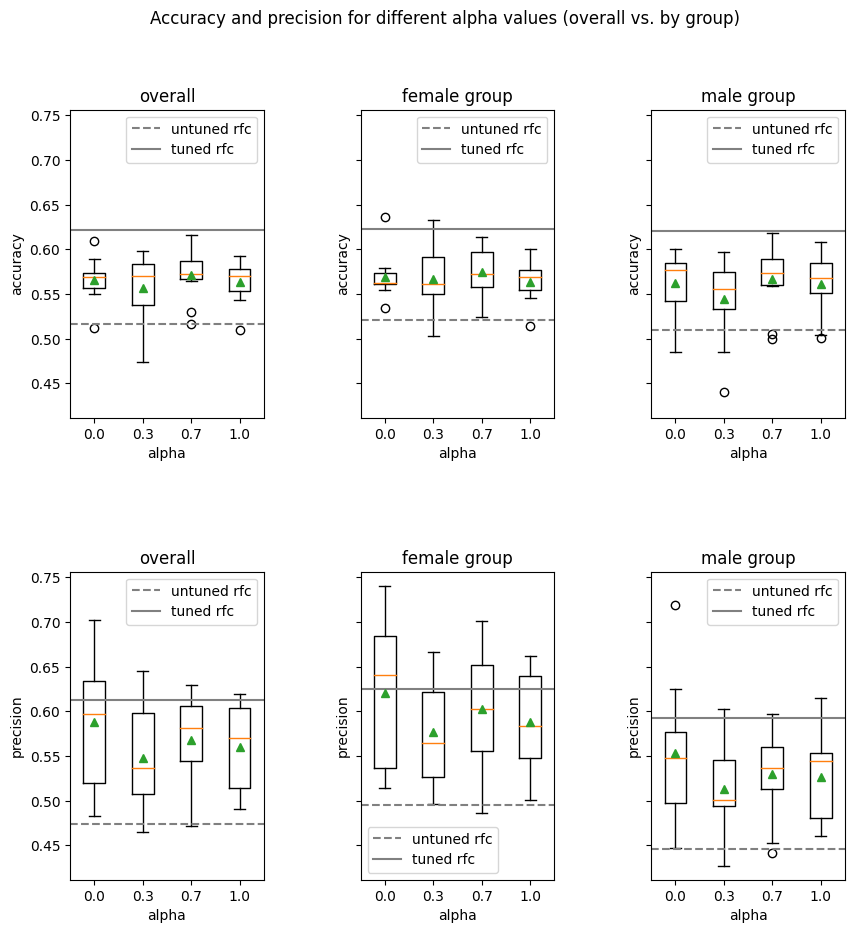

In [25]:
# inspection for the small box plots
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 10), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Accuracy and precision for different alpha values (overall vs. by group)')

for i, metric in enumerate(metric_list[:2]):
    # overall plot for that metric
    ax = axs.flatten()[3*i]
    data = metric_values_df.iloc[:,[i,i+10,i+20,i+30]]
    ax.boxplot(data, labels=alphas, showmeans=True)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('overall')
    ax.axhline(performance_table_a[metric].values[0], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[0], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

    # female plot for that metric
    ax = axs.flatten()[3*i+1]
    data = metric_values_df.iloc[:,[i+40,i+45,i+50,i+55]]
    ax.boxplot(data, labels=alphas, showmeans=True)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('female group')
    ax.axhline(performance_table_a[metric].values[1], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[1], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

    # male plot for that metric
    ax = axs.flatten()[3*i+2]
    data = metric_values_df.iloc[:,[i+60,i+65,i+70,i+75]]
    ax.boxplot(data, labels=alphas, showmeans=True)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('male group')
    ax.axhline(performance_table_a[metric].values[2], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[2], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

plt.show()

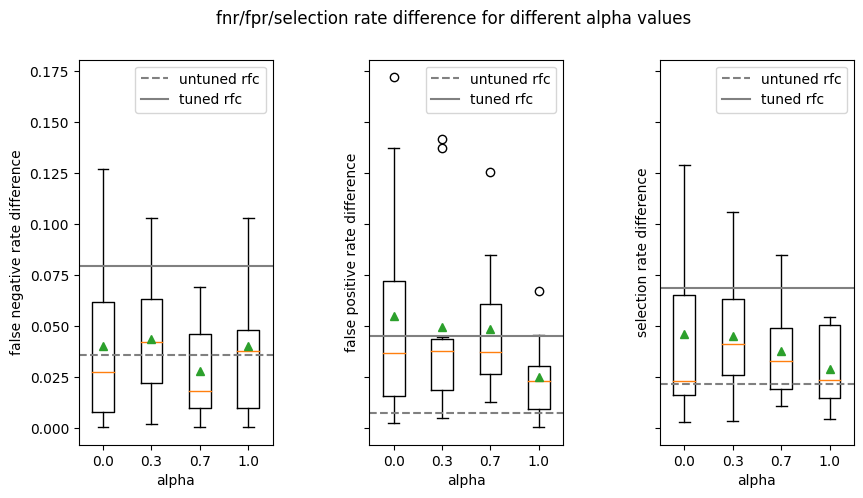

In [26]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 5), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('fnr/fpr/selection rate difference for different alpha values')
metric_list_index = [5,6,9]

for i in range(3):
    ax = axs.flatten()[i]
    data = metric_values_df.iloc[:,[metric_list_index[i],metric_list_index[i]+10,metric_list_index[i]+20,metric_list_index[i]+30]]
    ax.boxplot(data, labels=alphas, showmeans=True)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric_list[metric_list_index[i]])
    ax.axhline(performance_table_a[metric_list[metric_list_index[i]]].values[0], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric_list[metric_list_index[i]]].values[0], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

plt.show()

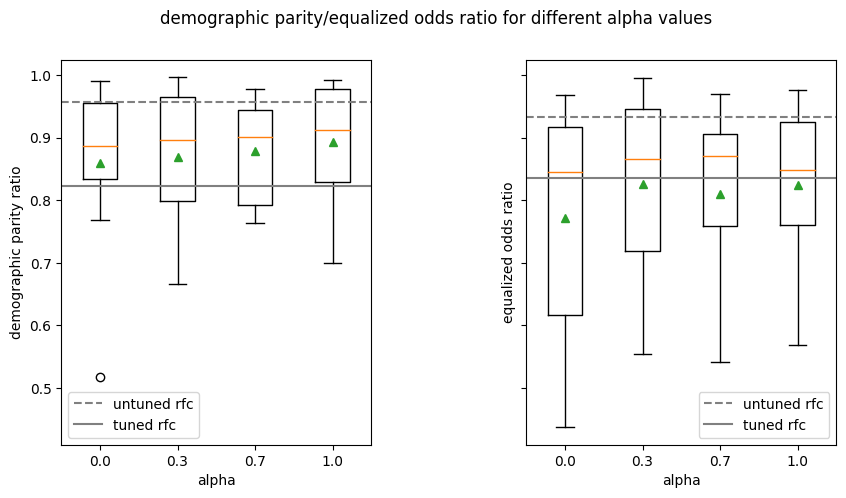

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('demographic parity/equalized odds ratio for different alpha values')
metric_list_index = [7,8]

for i in range(2):
    ax = axs.flatten()[i]
    data = metric_values_df.iloc[:,[metric_list_index[i],metric_list_index[i]+10,metric_list_index[i]+20,metric_list_index[i]+30]]
    ax.boxplot(data, labels=alphas, showmeans=True)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric_list[metric_list_index[i]])
    ax.axhline(performance_table_a[metric_list[metric_list_index[i]]].values[0], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric_list[metric_list_index[i]]].values[0], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

plt.show()

# Problem 4, Part (d)
### **Threshold Optimizer Post-processing intervention**



In [28]:
metric_values_df = metric_values_df.join(pd.DataFrame({col: [0.0] * 10 for col in [f'overall_to_m{j}' for j in range(1, 11)]}))
metric_values_df = metric_values_df.join(pd.DataFrame({col: [0.0] * 10 for col in [f'female_to_m{j}' for j in range(1, 6)]}))
metric_values_df = metric_values_df.join(pd.DataFrame({col: [0.0] * 10 for col in [f'male_to_m{j}' for j in range(1, 6)]}))
metric_values_df.head()

,overall_a1_m1,overall_a1_m2,overall_a1_m3,overall_a1_m4,overall_a1_m5,overall_a1_m6,overall_a1_m7,overall_a1_m8,overall_a1_m9,overall_a1_m10,...,female_to_m1,female_to_m2,female_to_m3,female_to_m4,female_to_m5,male_to_m1,male_to_m2,male_to_m3,male_to_m4,male_to_m5
0,0.573674,0.639485,0.159700,0.840300,0.076156,0.005442,0.038792,0.836318,0.601002,0.020620,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.609037,0.584530,0.557429,0.442571,0.345906,0.064669,0.171871,0.768943,0.608385,0.117675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.573674,0.608844,0.192060,0.807940,0.104167,0.023855,0.002497,0.891901,0.882049,0.016414,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.561886,0.525050,0.812823,0.187177,0.665108,0.007666,0.034720,0.965541,0.949030,0.025737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.588900,0.618018,0.354339,0.645661,0.198502,0.007847,0.015621,0.989893,0.924422,0.002770,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
#@markdown Fit the ThresholdOptimizer model here
for i, seed in enumerate(seeds):
    # split the data with different random states
    X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(x_numeric, y_raw, test_size=0.2, random_state=seed)

    # train the tuned random forest
    rfc = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=seed)
    rfc.fit(X_train_d, y_train_d)

    # make the post-processed model
    to_rfc = ThresholdOptimizer(
        estimator=rfc,
        constraints='demographic_parity',
        objective='balanced_accuracy_score',
        prefit=True,
        predict_method='predict_proba'
    )

    # fit the model to the training data
    to_rfc.fit(X_train_d, y_train_d, sensitive_features=X_train_d['gender_Male'])

    # predict on the test data
    y_pred_d = to_rfc.predict(X_test_d, sensitive_features=X_test_d['gender_Male'])

    sample_params_d = {
        'false negative rate difference':
            { 'sensitive_features': X_test_d['gender_Male'] },
        'false positive rate difference':
            { 'sensitive_features': X_test_d['gender_Male'] },
        'demographic parity ratio':
            { 'sensitive_features': X_test_d['gender_Male'] },
        'equalized odds ratio':
            { 'sensitive_features': X_test_d['gender_Male'] },
        'selection rate difference':
            { 'sensitive_features': X_test_d['gender_Male'] },
    }
    metric_frame_d = MetricFrame(
        metrics=metric_dict,
        y_true=y_test_d,
        y_pred=y_pred_d,
        sensitive_features=X_test_d['gender_Male'],
        sample_params=sample_params_d
    )

    overall_metrics_d = metric_frame_d.overall.to_dict()
    group_metrics_d =pd.DataFrame(metric_frame_d.by_group.to_dict())

    # append the metric values for this ThresholdOptimizer
    for k, metric in enumerate(metric_list):
        metric_values_df.iat[i, 80+k] = overall_metrics_d[metric]
        if k < 5:
            metric_values_df.iat[i, 90+k] = group_metrics_d.iat[0,k]
            metric_values_df.iat[i, 95+k] = group_metrics_d.iat[1,k]

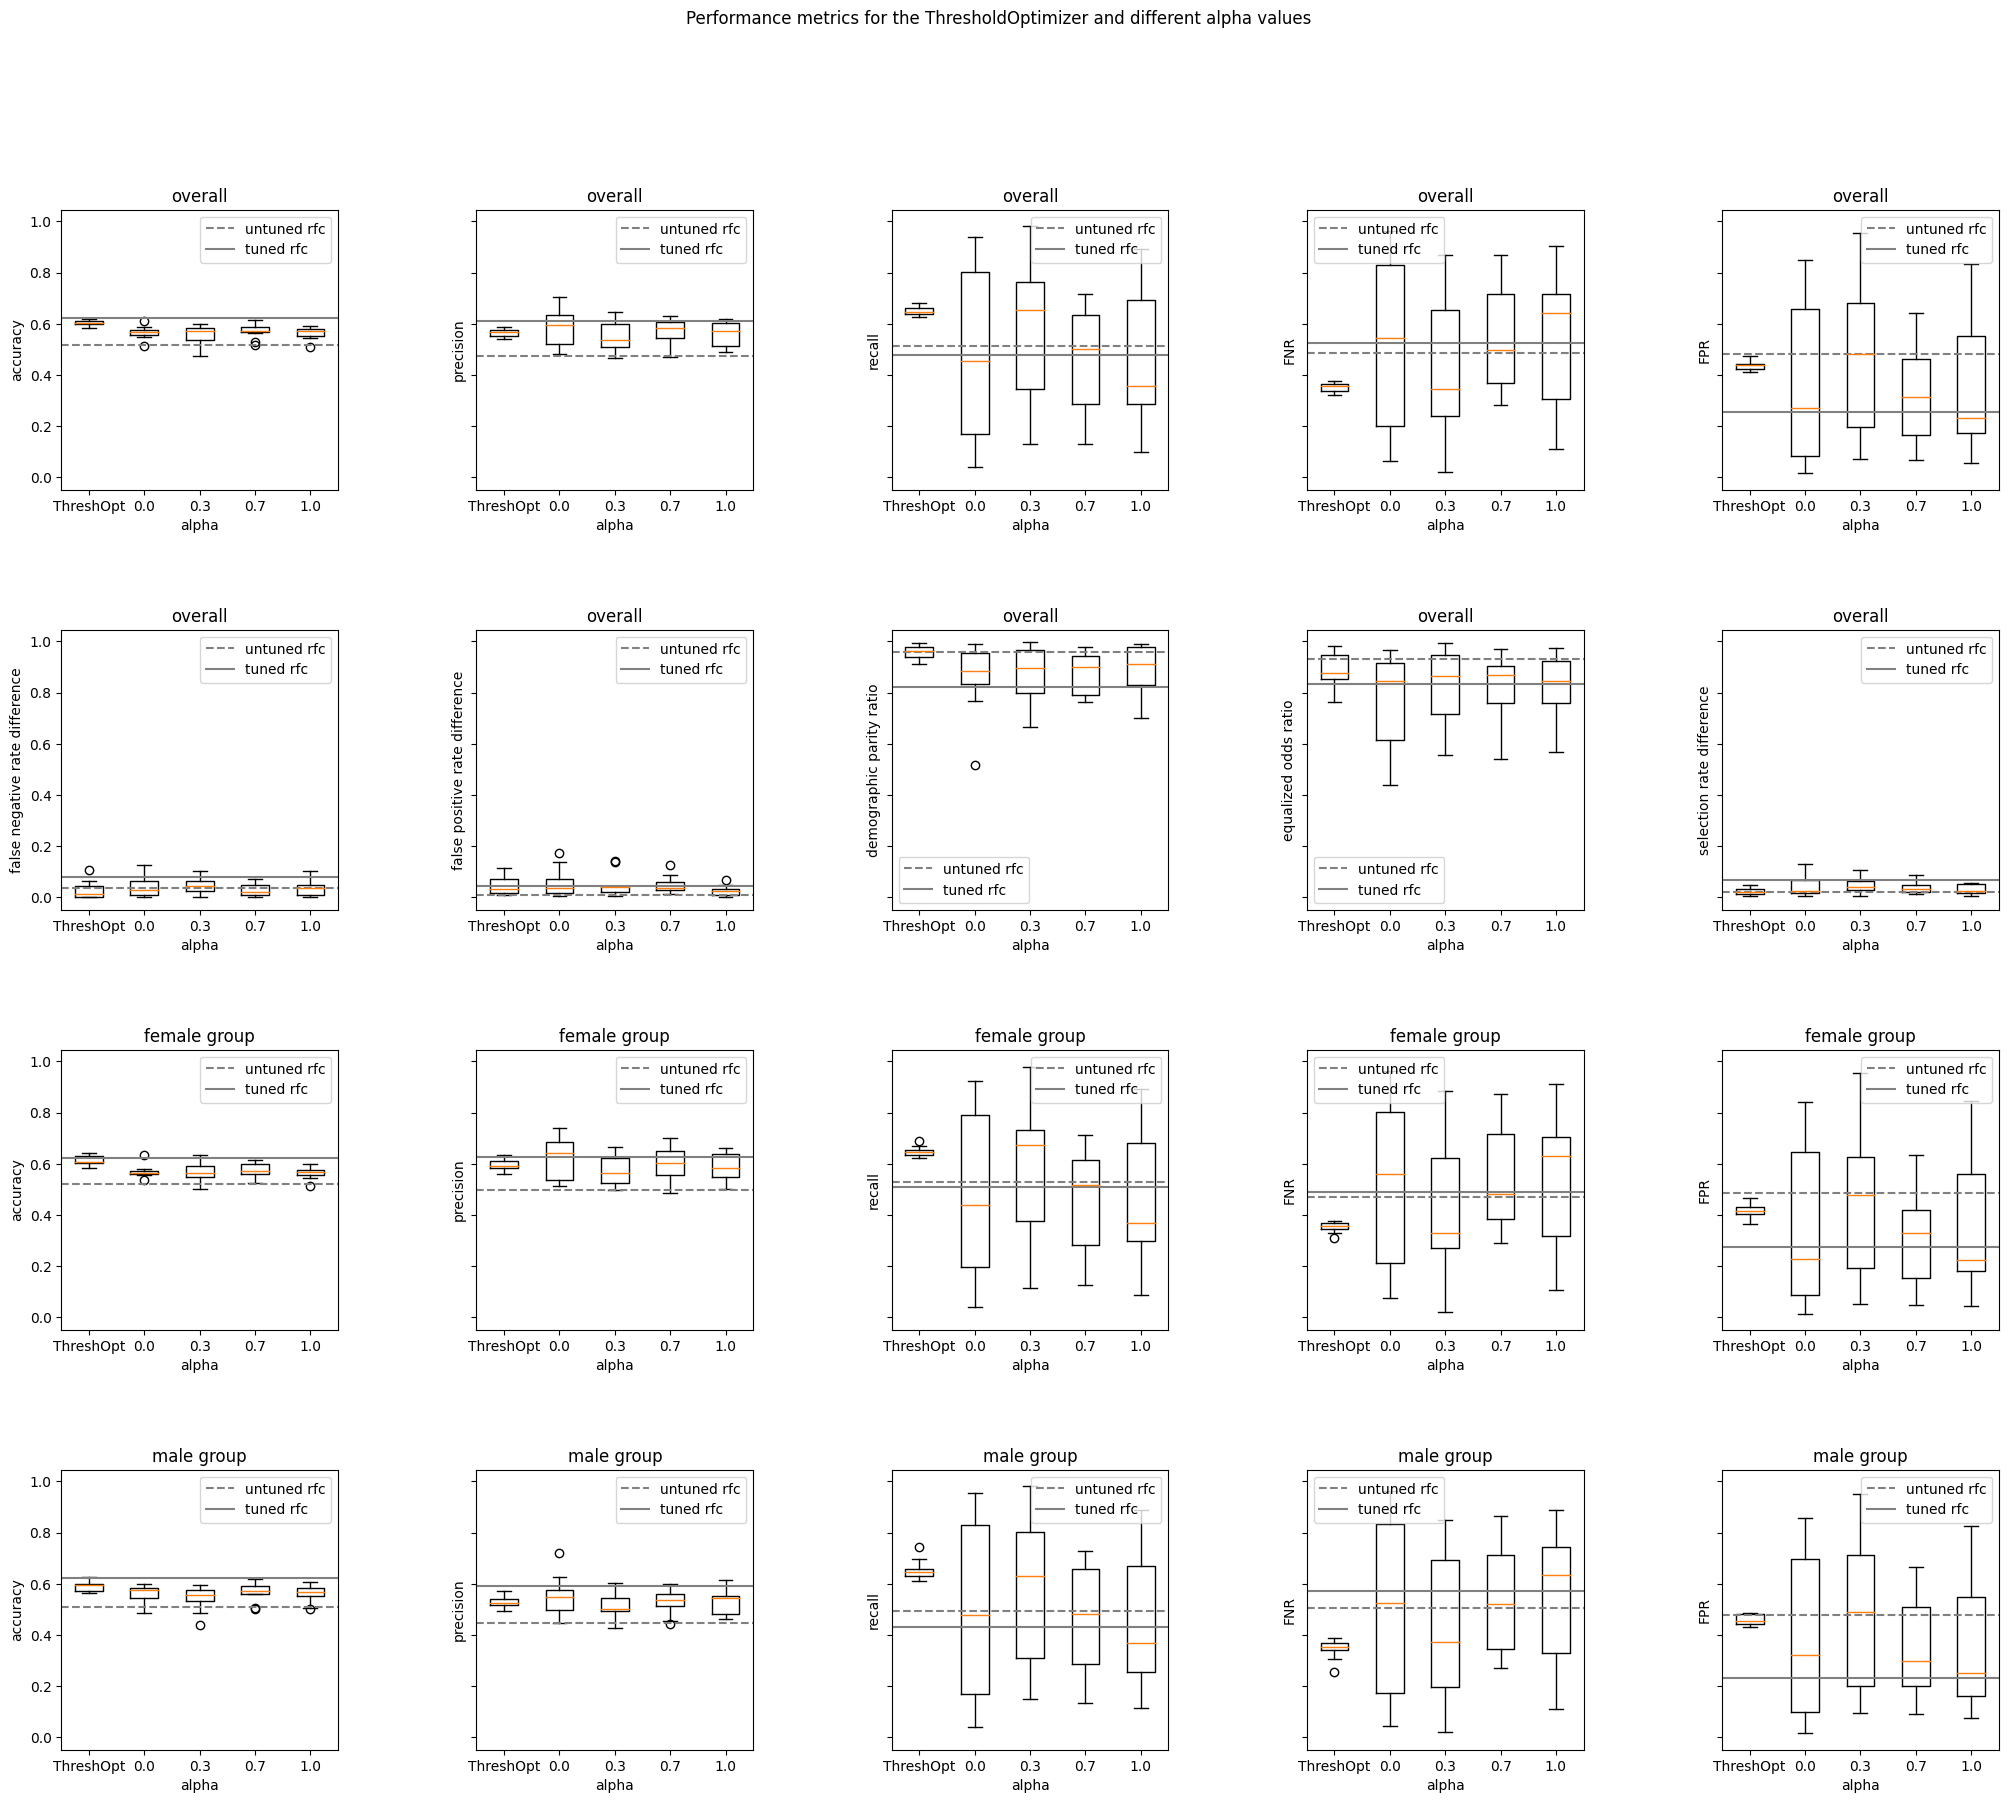

In [30]:
#@markdown ### Plot all our metrics as line plots while varying alpha
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(25, 20), sharey=True)
fig.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('Performance metrics for the ThresholdOptimizer and different alpha values')

alphas_d = ['ThreshOpt'] + alphas

for i, metric in enumerate(metric_list):
    # overall plot for that metric
    ax = axs.flatten()[i]
    data = metric_values_df.iloc[:,[i+80,i,i+10,i+20,i+30]]
    ax.boxplot(data, labels=alphas_d)
    ax.set_xlabel('alpha')
    ax.set_ylabel(metric)
    ax.set_title('overall')
    ax.axhline(performance_table_a[metric].values[0], color='grey', linestyle='--', label='untuned rfc')
    ax.axhline(performance_table_b[metric].values[0], color='grey', linestyle='-', label='tuned rfc')
    ax.legend()

    if i < 5:
        # female group plot for that metric
        ax = axs.flatten()[i+10]
        data = metric_values_df.iloc[:,[i+90,i+40,i+45,i+50,i+55]]
        ax.boxplot(data, labels=alphas_d)
        ax.set_xlabel('alpha')
        ax.set_ylabel(metric)
        ax.set_title('female group')
        ax.axhline(performance_table_a[metric].values[1], color='grey', linestyle='--', label='untuned rfc')
        ax.axhline(performance_table_b[metric].values[1], color='grey', linestyle='-', label='tuned rfc')
        ax.legend()

        # male group plot for that metric
        ax = axs.flatten()[i+15]
        data = metric_values_df.iloc[:,[i+95,i+60,i+65,i+70,i+75]]
        ax.boxplot(data, labels=alphas_d)
        ax.set_xlabel('alpha')
        ax.set_ylabel(metric)
        ax.set_title('male group')
        ax.axhline(performance_table_a[metric].values[2], color='grey', linestyle='--', label='untuned rfc')
        ax.axhline(performance_table_b[metric].values[2], color='grey', linestyle='-', label='tuned rfc')
        ax.legend()

plt.show()